#Importing necessary libraries

In [63]:
import requests
import json
import pandas as pd
import yfinance as yf
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

#Collecing Data

In [2]:
start_date = '20220301T0000'
end_date = '20231103T0000'

url = f"https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=TSLA&apikey=YT1SROOTAE2PCOAY&time_from={start_date}&time_to={end_date}&limit=1000&sort=EARLIEST"
payload={}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)
if response.status_code == 200:
    data = response.json()
    with open('response_data.json', 'w') as json_file:
        json.dump(data, json_file)
else:
    print("Error:", response.status_code)

with open('response_data.json', 'r') as json_file:
    data = json.load(json_file)



summaries = []
dates = []

for article in data['feed']:
    summaries.append(article['summary'])
    dates.append(article['time_published'])

# Creating a DataFrame
s = pd.DataFrame({
    'Summary': summaries,
    'time_published': dates
})


# Displaying the DataFrame with converted datetime
print(s)

s.to_csv('s.csv', index=False)

start_date = s.iloc[-1][-1][:-2]
print(start_date)

                                               Summary   time_published
0    Lucid Stock Sinks As Tesla Rival Slashes 2022 ...  20220301T080000
1    Live updates: Dow tumbles as Russia threatens ...  20220301T080000
2    BYD, China's biggest electric vehicle (EV) bui...  20220301T113014
3    China's three biggest makers of smart electric...  20220301T163019
4    Box Stock Jumps As Earnings Beat Estimates Inv...  20220302T080000
..                                                 ...              ...
690  A Thursday tweet from Tesla CEO Elon Musk seem...  20220318T161755
691  These are the stocks posting the largest moves...  20220318T163340
692  Detroit giant GM is in full transition to elec...  20220318T171700
693  Mike Novogratz issued an unusual challenge to ...  20220318T172000
694  Rivian's share price has fallen sharply, and a...  20220318T172900

[695 rows x 2 columns]
20220318T1729


We did so many iterartions like above and we put that it csv files like s,s1,s2........



In [11]:
df = pd.read_csv('/content/combined_file.csv')
df.head()

,Summary,time_published
0,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...,20220301T080000
1,Live updates: Dow tumbles as Russia threatens ...,20220301T080000
2,"BYD, China's biggest electric vehicle (EV) bui...",20220301T113014
3,China's three biggest makers of smart electric...,20220301T163019
4,Box Stock Jumps As Earnings Beat Estimates Inv...,20220302T080000


In [4]:
dataset = yf.download('TSLA',interval = '1d')

[*********************100%%**********************]  1 of 1 completed


In [3]:
#!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.6 MB/s eta 0:00:00


#Sentiment Analysis

In [6]:
# Load the tokenizer and model
MODEL_NAME = 'ProsusAI/finbert'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)


made use of 'finbert' pre-trained sentiment analysis model to identify the sentiments of text data. the text data is pre-processed using tokenizer.

In [8]:
# Define a function to predict sentiment
def predict_sentiment(text):
    # Tokenize the text and obtain predictions
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the predicted class
    pred_class = torch.argmax(logits, dim=1).item()
    # Map the predicted class index to its corresponding sentiment
    if pred_class == 0:
        return 'Negative'
    elif pred_class == 1:
        return 'Neutral'
    else:
        return 'Positive'

'predict_sentiment' is a user-defined prediction function that is used to predict the sentiment of text data. it takes the text input, tokenizes it and gives it to the loaded model. each model can have it's own definition for predicted class labels. finbert's predicted label has 0 for neg, 1 for neutral and 2 for pos.

In [9]:
predict_sentiment('Tesla gonna release his EV truck tomorrow')

'Positive'

In [12]:
#df['Sentiment'] = df['Summary'].apply(predict_sentiment)

sent = pd.read_csv('/content/sentiment_final (1).csv')
sent

,Summary,time_published,Sentiment
0,Futures Fall After Market Closes Poorly. Tesla...,20230301T001800,Positive
1,"Factbox: As Tesla prepares a Mexico plant, a l...",20230301T003700,Positive
2,U.S. markets ended the last trading day of Feb...,20230301T005443,Neutral
3,China is warning Twitter CEO Elon Musk against...,20230301T012054,Neutral
4,Twitter and Tesla CEO Elon Musk is in the cros...,20230301T012757,Positive
...,...,...,...
36451,NIO Earnings Are Coming. Tesla Investors Will ...,20230228T215000,Positive
36452,"SAN FRANCISCO, Feb. 28, 2023 ( GLOBE NEWSWIRE ...",20230228T220612,Positive
36453,NIO Earnings Are Coming. What to Expect. ...,20230228T224000,Positive
36454,Market Rally Closes Poorly Again. Tesla Settin...,20230228T233300,Neutral


In [13]:
sent['time_published'] = pd.to_datetime(sent['time_published'], format='%Y%m%dT%H%M%S')
sent['time_published'] = sent['time_published'].dt.date

In [14]:
most_frequent_sent = sent.groupby('time_published').agg(lambda x:x.value_counts().idxmax())
most_frequent_sent

,Summary,Sentiment
time_published,,
2022-03-01,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...,Neutral
2022-03-02,Box Stock Jumps As Earnings Beat Estimates Inv...,Positive
2022-03-03,Dow Jones Futures: Stock Market Rallies On 'Ni...,Positive
2022-03-04,One of the most successful of these projects c...,Positive
2022-03-05,Or will Germany change Elon Musk?,Positive
...,...,...
2023-10-31,"Apple Inc.'s AAPL ""Scary Fast"" event has concl...",Positive
2023-11-01,A California jury on Tuesday rejected a claim ...,Positive
2023-11-02,Troubles with the UAW and electric vehicles we...,Positive


#LSTM with OHLC

In [18]:
dataset.reset_index(inplace = True)
scalar = MinMaxScaler(feature_range=(0, 1))

In [19]:
def load_dataset(col_names, window,scalar, no_samples=None, starting=True):
    if not no_samples:
        no_samples = len(dataset)

    rdf = dataset.loc[:no_samples, col_names] if starting else dataset.loc[no_samples:, col_names]
    rdf_val = rdf.values

    rdf_val = rdf_val.astype(np.float64)

    # normalise

    rdf_val = scalar.fit_transform(rdf_val.reshape(-1, 1))


    st = time.time()


    ### Memory Efficient ##############################################################
    ndata = rdf_val.reshape((rdf_val.shape[0], 1))
    cdata = ndata[0:-window+0]
    for i in tqdm(range(1, window)):
           cdata = np.hstack((cdata, ndata[i:-window+i]))
    #####################################################################

    et = time.time() - st
    print(f"Loaded in: {et-st} sec")

    return cdata


In [29]:
rolling = load_dataset(col_names='High', window=101, scalar= scalar)

100%|██████████| 100/100 [00:00<00:00, 927.49it/s]

Loaded in: -1699140600.451602 sec


In [30]:
def train_test_split(cdata, pred_steps, shuffle=False):

    if shuffle:
        np.random.shuffle(cdata)

    train_days = int(0.80 * len(cdata))

    train = cdata[:train_days, :]
    test = cdata[train_days:, :]
    ## split into input and outputs
    train_X, train_y = train[:, :-pred_steps], train[:, -pred_steps:]
    test_X, test_y = test[:, :-pred_steps], test[:, -pred_steps:]

    ## reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, test_X, test_y

In [31]:
train_x, train_y, test_x, test_y = train_test_split(rolling, 1)

In [32]:
def lstm(
        data_x, data_y, test_x, test_y, in_features=100, out_features=1,
        loss='mean_squared_error', optimizer='adam', epochs=50, batch_size=64):
    ## design network
    model = Sequential()
    model.add(LSTM(in_features, return_sequences=True, input_shape=(data_x.shape[1], data_x.shape[2])))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dense(out_features))
    model.compile(loss=loss, optimizer=optimizer)

    ## fit network
    history = model.fit(data_x, data_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y),
                        verbose=1,
                        shuffle=True)
    #model.save(save_path)

    return model, history

In [33]:
def plot_lstm_history(history, save_path=None):
    pyplot.figure()
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    #pyplot.savefig()


def save_plot_xy(x, y, path=None):
    pyplot.figure()
    pyplot.plot(x)
    pyplot.plot(y)
    #pyplot.savefig()

In [34]:
PRED_STEPS = 1
WINDOW = 101
# DATASET_TIMESERIES = "30M"
# INDEX = "BANKNIFTY"
# DESC = f"{INDEX}_{DATASET_TIMESERIES}_{WINDOW}W_{PRED_STEPS}PTS"
#MODEL_CHECKPOINT = os.path.join("model_checkpoints", f"CHK_{time.asctime()}_{DESC}")

model, history = lstm(train_x, train_y, test_x=test_x, test_y=test_y,
                        epochs=10, batch_size=64, loss='mean_squared_error', optimizer='adam',
                        out_features=PRED_STEPS)

Epoch 1/10
41/41 [==============================] - 21s 215ms/step - loss: 0.0052 - val_loss: 0.0195
Epoch 2/10
41/41 [==============================] - 4s 102ms/step - loss: 4.8259e-04 - val_loss: 0.0247
Epoch 3/10
41/41 [==============================] - 3s 62ms/step - loss: 3.2667e-04 - val_loss: 0.0188
Epoch 4/10
41/41 [==============================] - 4s 91ms/step - loss: 2.6689e-04 - val_loss: 0.0116
Epoch 5/10
41/41 [==============================] - 7s 173ms/step - loss: 1.5628e-04 - val_loss: 0.0072
Epoch 6/10
41/41 [==============================] - 4s 101ms/step - loss: 1.4127e-04 - val_loss: 0.0140
Epoch 7/10
41/41 [==============================] - 4s 89ms/step - loss: 1.5556e-04 - val_loss: 0.0080
Epoch 8/10
41/41 [==============================] - 4s 95ms/step - loss: 1.2936e-04 - val_loss: 0.0089
Epoch 9/10
41/41 [==============================] - 5s 125ms/step - loss: 1.1359e-04 - val_loss: 0.0091
Epoch 10/10
41/41 [==============================] - 4s 92ms/step - los

21/21 [==============================] - 0s 10ms/step


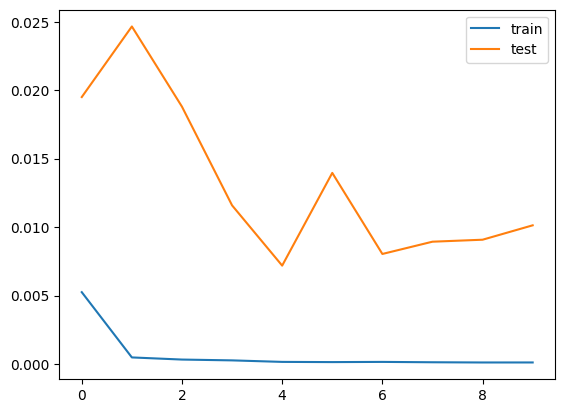

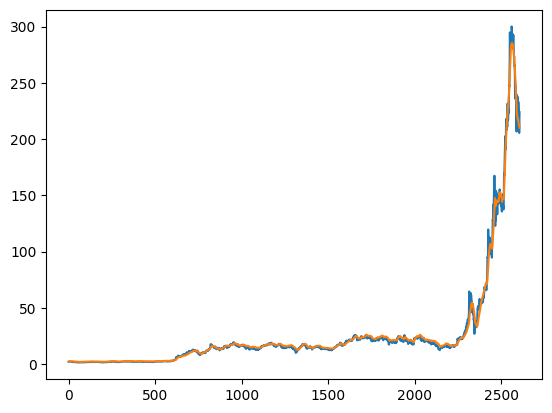

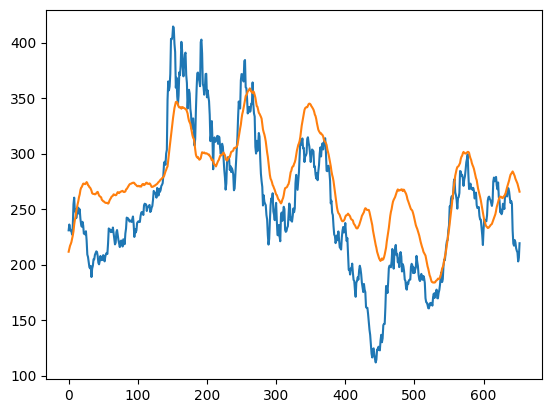

In [35]:
# make a prediction
train_x_pred = model.predict(train_x)
test_x_pred = model.predict(test_x)

plot_lstm_history(history)# os.path.join(MODEL_CHECKPOINT, "train_history.jpg"))

#invert scaling
train_x_pred = train_x_pred.reshape(train_x_pred.shape[0], train_x_pred.shape[1])
test_x_pred = test_x_pred.reshape(test_x_pred.shape[0], test_x_pred.shape[1])
train_x_pred = scalar.inverse_transform(train_x_pred)
test_x_pred = scalar.inverse_transform(test_x_pred)


# plot results
save_plot_xy(scalar.inverse_transform(train_y[:, 0].reshape(-1, 1)),
             train_x_pred[:, 0].reshape(-1, 1))

save_plot_xy(scalar.inverse_transform(test_y[:, 0].reshape(-1, 1)),
             test_x_pred[:, 0].reshape(-1, 1))

#LSTM with LLM

In [95]:
data = yf.download('TSLA',period='2Y')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-04,411.470001,414.496674,405.666656,409.970001,409.970001,76192200
2021-11-05,409.333344,413.290009,402.666656,407.363342,407.363342,64886400
2021-11-08,383.263336,399.000000,377.666656,387.646667,387.646667,100337100
2021-11-09,391.200012,391.500000,337.173340,341.166656,341.166656,177317400
2021-11-10,336.803345,359.366669,329.103333,355.983337,355.983337,128408100
...,...,...,...,...,...,...
2023-10-30,209.279999,210.880005,194.669998,197.360001,197.360001,136448200
2023-10-31,196.119995,202.800003,194.070007,200.839996,200.839996,118068300
2023-11-01,204.039993,205.990005,197.850006,205.660004,205.660004,121661700


In [98]:
most_frequent_sent = most_frequent_sent.rename(columns={'time_published':'Date'})
most_frequent_sent['Date'] = pd.to_datetime(most_frequent_sent['Date'])

In [99]:
df = pd.merge(most_frequent_sent,data,how ='inner',on = 'Date')
df

,index,Date,Summary,Sentiment,Open,High,Low,Close,Adj Close,Volume
0,0,2022-03-01,Lucid Stock Sinks As Tesla Rival Slashes 2022 ...,Neutral,289.893341,296.626678,284.593323,288.123322,288.123322,74766900
1,1,2022-03-02,Box Stock Jumps As Earnings Beat Estimates Inv...,Positive,290.709991,295.493347,281.423340,293.296661,293.296661,74643300
2,2,2022-03-03,Dow Jones Futures: Stock Market Rallies On 'Ni...,Positive,292.923340,295.480011,277.533325,279.763336,279.763336,61623600
3,3,2022-03-04,One of the most successful of these projects c...,Positive,283.033325,285.216675,275.053345,279.429993,279.429993,66999600
4,6,2022-03-07,"The prize: batteries that would be cheaper, fa...",Negative,285.433319,288.713318,268.190002,268.193329,268.193329,72494100
...,...,...,...,...,...,...,...,...,...,...
419,608,2023-10-30,Humanoid Robot Market to grow by USD 16.05 bil...,Positive,209.279999,210.880005,194.669998,197.360001,197.360001,136448200
420,609,2023-10-31,"Apple Inc.'s AAPL ""Scary Fast"" event has concl...",Positive,196.119995,202.800003,194.070007,200.839996,200.839996,118068300
421,610,2023-11-01,A California jury on Tuesday rejected a claim ...,Positive,204.039993,205.990005,197.850006,205.660004,205.660004,121661700
422,611,2023-11-02,Troubles with the UAW and electric vehicles we...,Positive,212.970001,219.199997,211.449997,218.509995,218.509995,125987600


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 423
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      424 non-null    int64         
 1   Date       424 non-null    datetime64[ns]
 2   Summary    424 non-null    object        
 3   Sentiment  424 non-null    object        
 4   Open       424 non-null    float64       
 5   High       424 non-null    float64       
 6   Low        424 non-null    float64       
 7   Close      424 non-null    float64       
 8   Adj Close  424 non-null    float64       
 9   Volume     424 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 36.4+ KB


In [101]:
df = df.drop(['index','Summary', 'Open','Low','Close','Adj Close','Volume'], axis=1)

In [102]:
df

,Date,Sentiment,High
0,2022-03-01,Neutral,296.626678
1,2022-03-02,Positive,295.493347
2,2022-03-03,Positive,295.480011
3,2022-03-04,Positive,285.216675
4,2022-03-07,Negative,288.713318
...,...,...,...
419,2023-10-30,Positive,210.880005
420,2023-10-31,Positive,202.800003
421,2023-11-01,Positive,205.990005
422,2023-11-02,Positive,219.199997


In [103]:
df = pd.get_dummies(df, columns=['Sentiment'])

# Scale the 'Close' prices
scaler = StandardScaler()
df['High'] = scaler.fit_transform(df[['High']].values)

# Prepare input features, including sentiment and close prices
features = df.drop('Date', axis=1).values

In [104]:
df

,Date,High,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,2022-03-01,1.041315,0,1,0
1,2022-03-02,1.020827,0,0,1
2,2022-03-03,1.020586,0,0,1
3,2022-03-04,0.835050,0,0,1
4,2022-03-07,0.898261,1,0,0
...,...,...,...,...,...
419,2023-10-30,-0.508776,0,0,1
420,2023-10-31,-0.654843,0,0,1
421,2023-11-01,-0.597176,0,0,1
422,2023-11-02,-0.358371,0,0,1


In [105]:
sequence_length = 2

# We need to create a sequence for each input feature
n_features = features.shape[1]  # This is the number of features including the one-hot encoded sentiment
X = []
y = []

for i in range(sequence_length, len(df)):
    X.append(features[i-sequence_length:i])
    y.append(features[i, df.columns.get_loc('High') - 1])  # Get the index for 'Close' column

X, y = np.array(X), np.array(y)

In [106]:
# Initialize the LSTM model
model = Sequential()

# Adding the first LSTM layer with Dropout
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, n_features)))


# Adding a second LSTM layer, no need to specify input_shape
model.add(LSTM(units=256, return_sequences=False))


# Adding the output layer
model.add(Dense(units=1))

# Compiling the LSTM
model.compile(optimizer='adam', loss='mean_squared_error')

In [107]:
# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
11/11 [==============================] - 6s 19ms/step - loss: 0.9308
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 0.2231
Epoch 3/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0941
Epoch 4/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0487
Epoch 5/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0435
Epoch 6/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0402
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 0.0380
Epoch 8/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0383
Epoch 9/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0380
Epoch 10/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0371
Epoch 11/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0369
Epoch 12/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0370
Epoch 13/100
11/11 [=====

In [108]:
# Making predictions
predicted_close_prices = model.predict(X_test)

# Unscale the predicted closing prices
predicted_close_prices = scaler.inverse_transform(predicted_close_prices)

3/3 [==============================] - 1s 14ms/step


In [109]:
rmse = sqrt(mean_squared_error(y_test, predicted_close_prices))
print(f'Test RMSE: {rmse}')

Test RMSE: 255.5020644544295


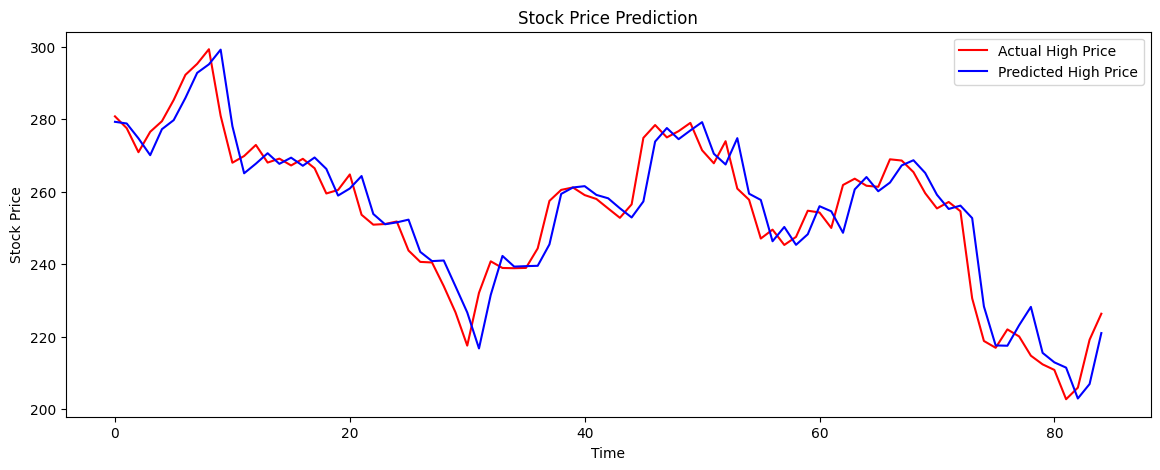

In [111]:
# Assuming y_test and predicted_close_prices are already defined and have the same length

# We need to rescale the y_test data back to its original scale
actual_close_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(14,5))
plt.plot(actual_close_prices, color='red', label='Actual High Price')
plt.plot(predicted_close_prices, color='blue', label='Predicted High Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()